In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import mdtraj as md
import matplotlib.pyplot as plt
from mdtraj.formats import PDBTrajectoryFile

In [55]:
# Define construct and load trajectory files for three replicas
construct = "8HDO_HIP"
traj_repl = [
    md.load('./'+construct+'-traj_centered_skip.rep_1.xtc', top='./'+construct+'-start.rep_1.gro'),
    md.load('./'+construct+'-traj_centered_skip.rep_2.xtc', top='./'+construct+'-start.rep_2.gro'),
    md.load('./'+construct+'-traj_centered_skip.rep_3.xtc', top='./'+construct+'-start.rep_3.gro')
]
# Heavy atoms of ligand L01 
atom_selection_lig_heavy = traj_repl[0].topology.select('(resn L01 and not symbol H)')

In [56]:
#I always check the atom names beforehand to ensure the selection is accurate
atom_names = [atom.name for atom in traj_repl[0].topology.atoms if atom.residue.name == "L01" and not atom.element.symbol == 'H']
print (atom_names)

['N00', 'C01', 'C02', 'C03', 'C04', 'N05', 'S06', 'C07', 'C08', 'C09', 'C0A', 'C0B', 'C0C', 'C0D', 'N0E', 'C0F', 'N0I', 'O0J', 'C0O', 'C0Q', 'N0R', 'C0V', 'O0X', 'C0Y', 'C0Z', 'C13', 'C14']


In [57]:
# Define the selection string for ligand (adjust residue name as needed)
ligand_atoms = traj_repl[0].topology.select('(resn L01 and not symbol H)')

# Create an empty list to store RMSF values for each replica (for each atom)
rmsf_lig_heavy_data = []

# Loop through each replica to compute RMSF for ligand heavy atoms
for traj in traj_repl:
    # Align frames
    traj_al = traj.superpose(traj, frame=0, atom_indices=ligand_atoms)
    
    # Take the last 90 frames for analysis
    used_frames = traj_al[-90:]  # Assuming num_used_frames = 90
    
    # RMSF for heavy atoms in the ligand (individual atom RMSF, not averaged over atoms)
    rmsf_lig_heavy = np.sqrt(3 * np.mean((used_frames.atom_slice(ligand_atoms).xyz - traj_al.atom_slice(ligand_atoms).xyz[0])**2, axis=(0, 2))) * 10
    
    # Append the RMSF for each atom in the ligand (no averaging over atoms)
    rmsf_lig_heavy_data.append(rmsf_lig_heavy)

# Check the lengths of RMSF data for each replica (if needed)
print(len(rmsf_lig_heavy_data[0]), len(rmsf_lig_heavy_data[1]), len(rmsf_lig_heavy_data[2]))

# Get atom names from the topology (for the selected ligand heavy atoms)
atom_names = [traj_repl[0].topology.atom(i).name for i in ligand_atoms]

# Create the DataFrame for ligand heavy atom RMSF across replicas (one column per replica)
df_rmsf_lig_heavy = pd.DataFrame(rmsf_lig_heavy_data[0], columns=[f'Replica_1'], index=atom_names)
df_rmsf_lig_heavy['Replica_2'] = rmsf_lig_heavy_data[1]
df_rmsf_lig_heavy['Replica_3'] = rmsf_lig_heavy_data[2]

# DataFrame to CSV
csv_path_rmsf = './rmsf_lig_heavy_data_' + construct + '.csv'
df_rmsf_lig_heavy.to_csv(csv_path_rmsf)

print(f"RMSF for ligand heavy atoms saved to: {csv_path_rmsf}")



27 27 27
RMSF for ligand heavy atoms saved to: ./rmsf_lig_heavy_data_8HDO_HIP.csv


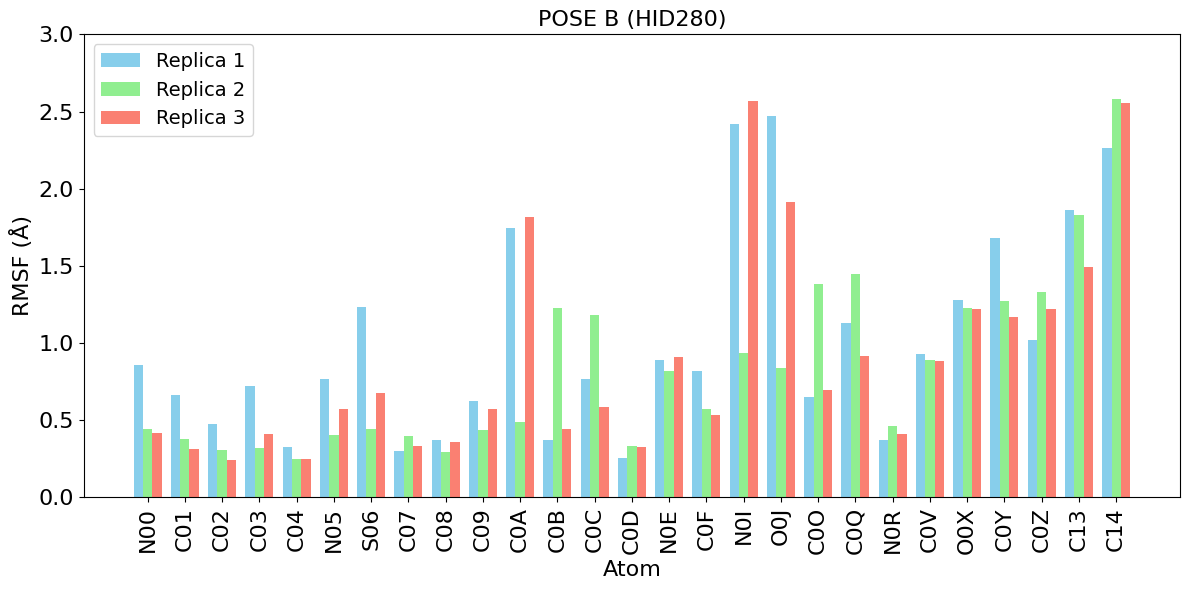

In [58]:
#3xreplica separated

# Create the figure and axes for plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Set up colors for each replica
colors = ['skyblue', 'lightgreen', 'salmon']

# Loop through each replica and plot the RMSF for each atom
for i, (rmsf_values, color) in enumerate(zip(rmsf_lig_heavy_data, colors)):
    # Plot the RMSF values for the current replica
    ax.bar(np.arange(len(rmsf_values)) + i * 0.25, rmsf_values, width=0.25, color=color, label=f'Replica {i+1}')

# Set x-axis labels to the atom names
ax.set_xticks(np.arange(len(atom_names)) + 0.25)  # Adjusting to center the tick marks
ax.set_xticklabels(atom_names, rotation=90, fontsize=16)

# Set y-axis tick font size
ax.tick_params(axis='y', labelsize=16)

# Set labels and title
ax.set_xlabel('Atom', fontsize=16)
ax.set_ylabel('RMSF (Å)', fontsize=16)
ax.set_title(f'POSE B (HID280)', fontsize=16)

# Add a legend
ax.legend(fontsize=14)

# Set y-axis limit to 0–3
ax.set_ylim(0, 3)

# Save the plot to a PNG file
png_path = './rmsf_ligand_heavy_atoms_' + construct + '.png'
plt.tight_layout()
plt.savefig(png_path, format='png')

# Show the plot
plt.show()

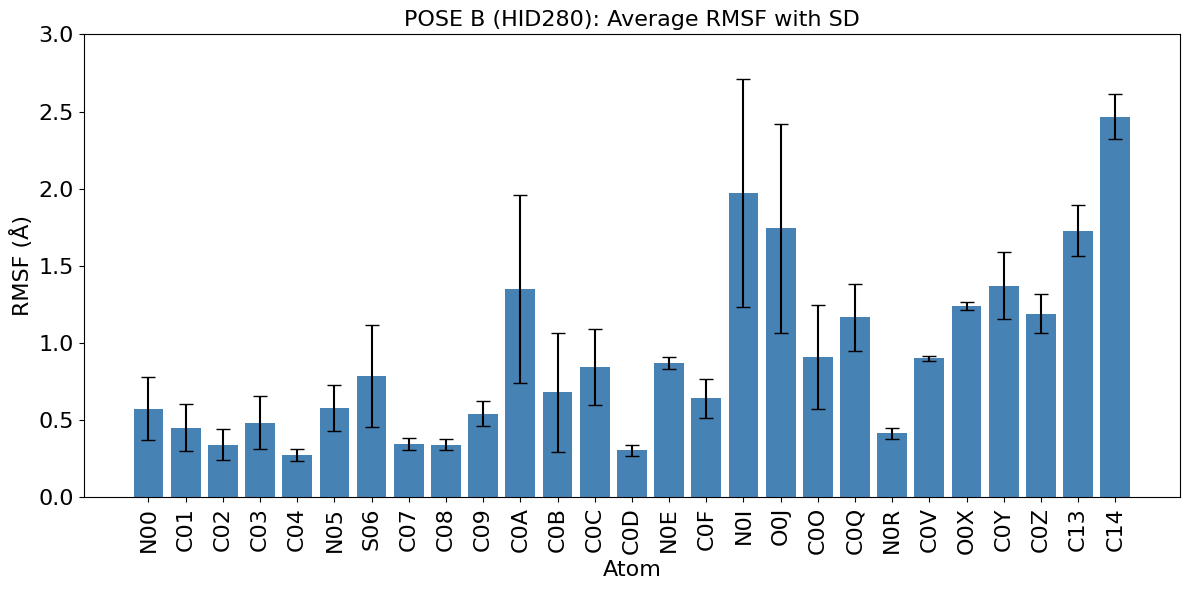

In [59]:
#AVERAGE RMSF VALUES + SD

# Compute average RMSF and standard deviation per atom across replicas
rmsf_avg = np.mean(rmsf_lig_heavy_data, axis=0)
rmsf_std = np.std(rmsf_lig_heavy_data, axis=0)

# Create the figure and axes for plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the average RMSF with error bars (standard deviation)
ax.bar(np.arange(len(atom_names)), rmsf_avg, yerr=rmsf_std, capsize=5, color='steelblue', label='Average RMSF')

# Set x-axis labels to the atom names
ax.set_xticks(np.arange(len(atom_names)))
ax.set_xticklabels(atom_names, rotation=90, fontsize=16)

# Set y-axis tick font size
ax.tick_params(axis='y', labelsize=16)

# Set labels and title
ax.set_xlabel('Atom', fontsize=16)
ax.set_ylabel('RMSF (Å)', fontsize=16)
ax.set_title(f'POSE B (HID280): Average RMSF with SD', fontsize=16)

# Set y-axis limit to 0–3
ax.set_ylim(0, 3)

# Save the plot to a PNG file
png_path_avg = './rmsf_avg_with_sd_' + construct + '.png'
plt.tight_layout()
plt.savefig(png_path_avg, format='png')

# Show the plot
plt.show()


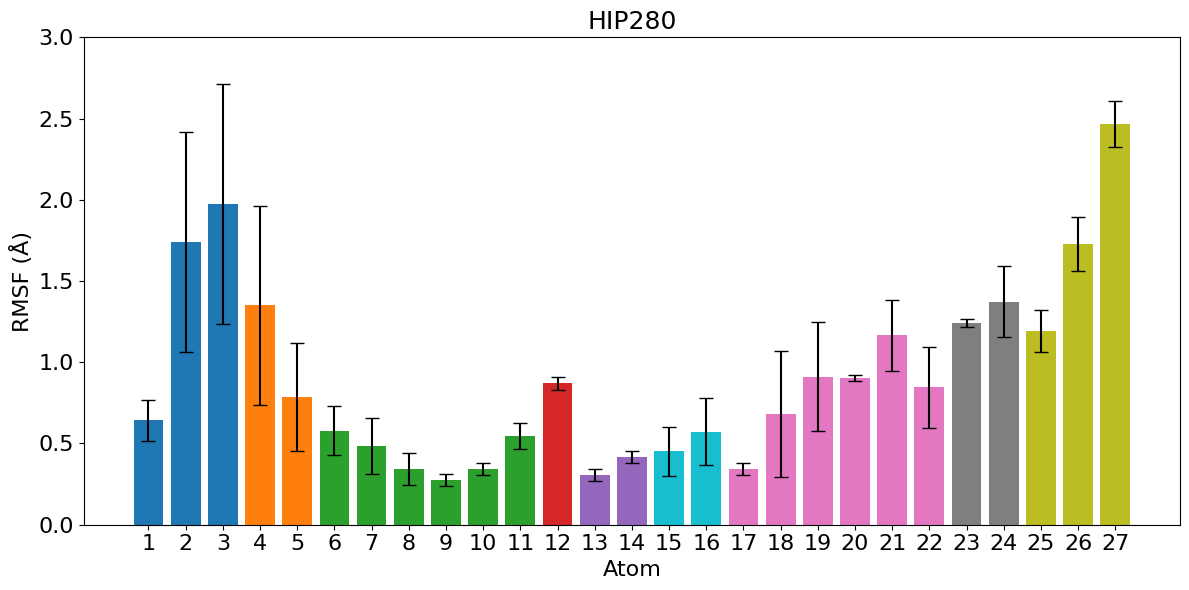

In [60]:
#The next part of the code allows you to display atoms in a predefined order and define groups, such as different functional groups.
# Atom order
atom_order = [
    'C0F', 'O0J', 'N0I', 
    'C0A', 'S06', 
    'N05', 'C03', 'C02', 'C04', 'C08', 'C09', 
    'N0E', 
    'C0D', 'N0R', 
    'C01', 'N00', 
    'C07', 'C0B', 'C0O', 'C0V', 'C0Q', 'C0C', 
    'O0X', 'C0Y', 
    'C0Z', 'C13', 'C14'
]
groups = [
    ['N0I', 'C0F', 'O0J'],  # Group 1
    ['C0A', 'S06'],         # Group 2
    ['N05', 'C03', 'C02', 'C04', 'C08', 'C09'],  # Group 3
    ['N0E'],               # Group 4
    ['C0D', 'N0R'],         # Group 5
    ['C01', 'N00'],         # Group 6
    ['C07', 'C0B', 'C0O', 'C0V', 'C0Q', 'C0C'],  # Group 7
    ['O0X', 'C0Y'],         # Group 8
    ['C0Z', 'C13', 'C14']   # Group 9
]

# Generate numeric labels (1, 2, ...)
numeric_labels = [str(i + 1) for i in range(len(atom_order))]

# Assign a color for each group
#group_colors = [
   # 'skyblue', 'lightgreen', 'salmon', 'gold', 'purple',
   # 'orange', 'steelblue', 'pink', 'lightgrey'
#]

group_colors = [
    '#1f77b4',  # Vibrant Blue
    '#ff7f0e',  # Vibrant Orange
    '#2ca02c',  # Vibrant Green
    '#d62728',  # Vibrant Red
    '#9467bd',  # Vibrant Purple
    '#17becf',  # Vibrant Cyan
    '#e377c2',  # Vibrant Pink
    '#7f7f7f',  # Vibrant Grey
    '#bcbd22'   # Vibrant Yellow-Green
]

# Reorder the data according to the specified atom order
reordered_indices = [atom_names.index(atom) for atom in atom_order]
rmsf_avg_reordered = [rmsf_avg[i] for i in reordered_indices]
rmsf_std_reordered = [rmsf_std[i] for i in reordered_indices]

# Group assignments for visualization
atom_to_group = {}
for group_idx, group in enumerate(groups):
    for atom in group:
        atom_to_group[atom] = group_idx

# Create the figure and axes for plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each atom's RMSF with the color of its group
for idx, (atom, avg, std) in enumerate(zip(atom_order, rmsf_avg_reordered, rmsf_std_reordered)):
    group_idx = atom_to_group[atom]
    ax.bar(idx, avg, yerr=std, capsize=5, color=group_colors[group_idx], label=f'Group {group_idx+1}' if idx == atom_order.index(groups[group_idx][0]) else "")

# Set x-axis labels to the reordered atom names
ax.set_xticks(np.arange(len(numeric_labels)))
ax.set_xticklabels(numeric_labels, rotation=0, fontsize=16)

# Set y-axis tick font size
ax.tick_params(axis='y', labelsize=16)

# Set labels and title
ax.set_xlabel('Atom', fontsize=16)
ax.set_ylabel('RMSF (Å)', fontsize=16)
ax.set_title(f'HIP280', fontsize=18)

# Add a legend (avoid duplicate labels)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
#ax.legend(by_label.values(), by_label.keys(), fontsize=14, loc='upper right')

# Set y-axis limit to 0–3
ax.set_ylim(0, 3)

# Save the plot to a PNG file
png_path_avg_grouped = './rmsf_avg_with_sd_grouped_' + construct + '.png'
plt.tight_layout()
plt.savefig(png_path_avg_grouped, format='png')

# Show the plot
plt.show()
